In [23]:
import mne
import os

# Directorio donde se encuentran los archivos EEG
directorio_datos = r"C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms"

# Diccionario para almacenar los registros EEG por condición
registros_eeg = {"congruente": {}, "incongruente_rel": {}, "incongruente_no_rel": {}}

# Condiciones y sus sufijos de archivo correspondientes
condiciones = {
    "congruente": "PWI_CON",
    "incongruente_rel": "PWI_INC_REL",
    "incongruente_no_rel": "PWI_INC_UNREL"
}

# Sujetos a excluir de la carga de archivos, pero deben aparecer en el diccionario
sujetos_excluir = {11, 30}

# Iterar sobre los 40 sujetos para cada condición
for sujeto_id in range(1, 41):
    for condicion, sufijo_archivo in condiciones.items():
        sujeto_key = f"Sujeto_{sujeto_id}"

        if sujeto_id in sujetos_excluir:
            registros_eeg[condicion][sujeto_key] = None
            print(f"{sujeto_key} excluido de la carga en '{condicion}', asignado como None.")
            continue  # Saltar a la siguiente condición

        nombre_archivo = f"S{sujeto_id}_{sufijo_archivo}.set"
        ruta_archivo = os.path.join(directorio_datos, nombre_archivo)

        try:
            # Cargar el archivo .set como un registro continuo
            registro_continuo = mne.io.read_raw_eeglab(ruta_archivo)
            registros_eeg[condicion][sujeto_key] = registro_continuo
            print(f"{nombre_archivo} cargado exitosamente en '{condicion}'.")
        except FileNotFoundError:
            registros_eeg[condicion][sujeto_key] = None
            print(f"{nombre_archivo} no encontrado en '{condicion}'.")
        except Exception as e:
            registros_eeg[condicion][sujeto_key] = None
            print(f"Error al cargar {nombre_archivo} en '{condicion}': {e}")

# Resumen de la carga de archivos
# print("\nResumen de las cargas:")
# for condicion, sujetos in registros_eeg.items():
#     print(f"\nCondición: {condicion}")
#     for sujeto, datos in sujetos.items():
#         estado = "Cargado" if datos is not None else "No cargado"
#         print(f"  {sujeto}: {estado}")


Reading C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms\S1_PWI_CON.fdt
S1_PWI_CON.set cargado exitosamente en 'congruente'.
Reading C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms\S1_PWI_INC_REL.fdt
S1_PWI_INC_REL.set cargado exitosamente en 'incongruente_rel'.
Reading C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms\S1_PWI_INC_UNREL.fdt
S1_PWI_INC_UNREL.set cargado exitosamente en 'incongruente_no_rel'.
Reading C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms\S2_PWI_CON.fdt
S2_PWI_CON.set cargado exitosamente en 'congruente'.
Reading C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS\Set_Average_por_Sujeto_1000ms\S2_PWI_INC_REL.fdt
S2_PWI_INC_REL.set cargado exitosamente en 'incongruente_rel'.
Reading C:\Users\Usuario\Documents\Datos EEG\PWI_DATOS_EEG_PROCESADOS_BUENOS

In [2]:
import pickle

with open('results/p_values_electrodes_greater_FDR_v4.pkl', 'rb') as f:
    p_values_greater_fdr = pickle.load(f)


In [3]:
import pickle

with open('results/p_values_electrodes_less_FDR_v4.pkl', 'rb') as f:
    p_values_less_fdr = pickle.load(f)


In [4]:
import numpy as np

def marcar_clusters_significativos(pvals, alpha=0.05, min_cluster_size=6):
    pvals = np.array(pvals)
    significativos = pvals < alpha
    resultado = np.ones_like(pvals)

    # Buscar clústeres contiguos
    start = 0
    while start < len(significativos):
        if significativos[start]:
            end = start
            while end < len(significativos) and significativos[end]:
                end += 1
            if end - start >= min_cluster_size:
                resultado[start:end] = pvals[start:end]
            start = end
        else:
            start += 1

    return resultado.tolist()


In [5]:
greater_clusters = {}
less_clusters = {}

for electrodo in p_values_greater_fdr:
    greater_clusters[electrodo] = {}
    less_clusters[electrodo] = {}

    for comparacion in p_values_greater_fdr[electrodo]:
        p_greater = p_values_greater_fdr[electrodo][comparacion]
        p_less = p_values_less_fdr[electrodo][comparacion]

        # Aplicar clústeres
        greater_clusters[electrodo][comparacion] = marcar_clusters_significativos(p_greater)
        less_clusters[electrodo][comparacion] = marcar_clusters_significativos(p_less)

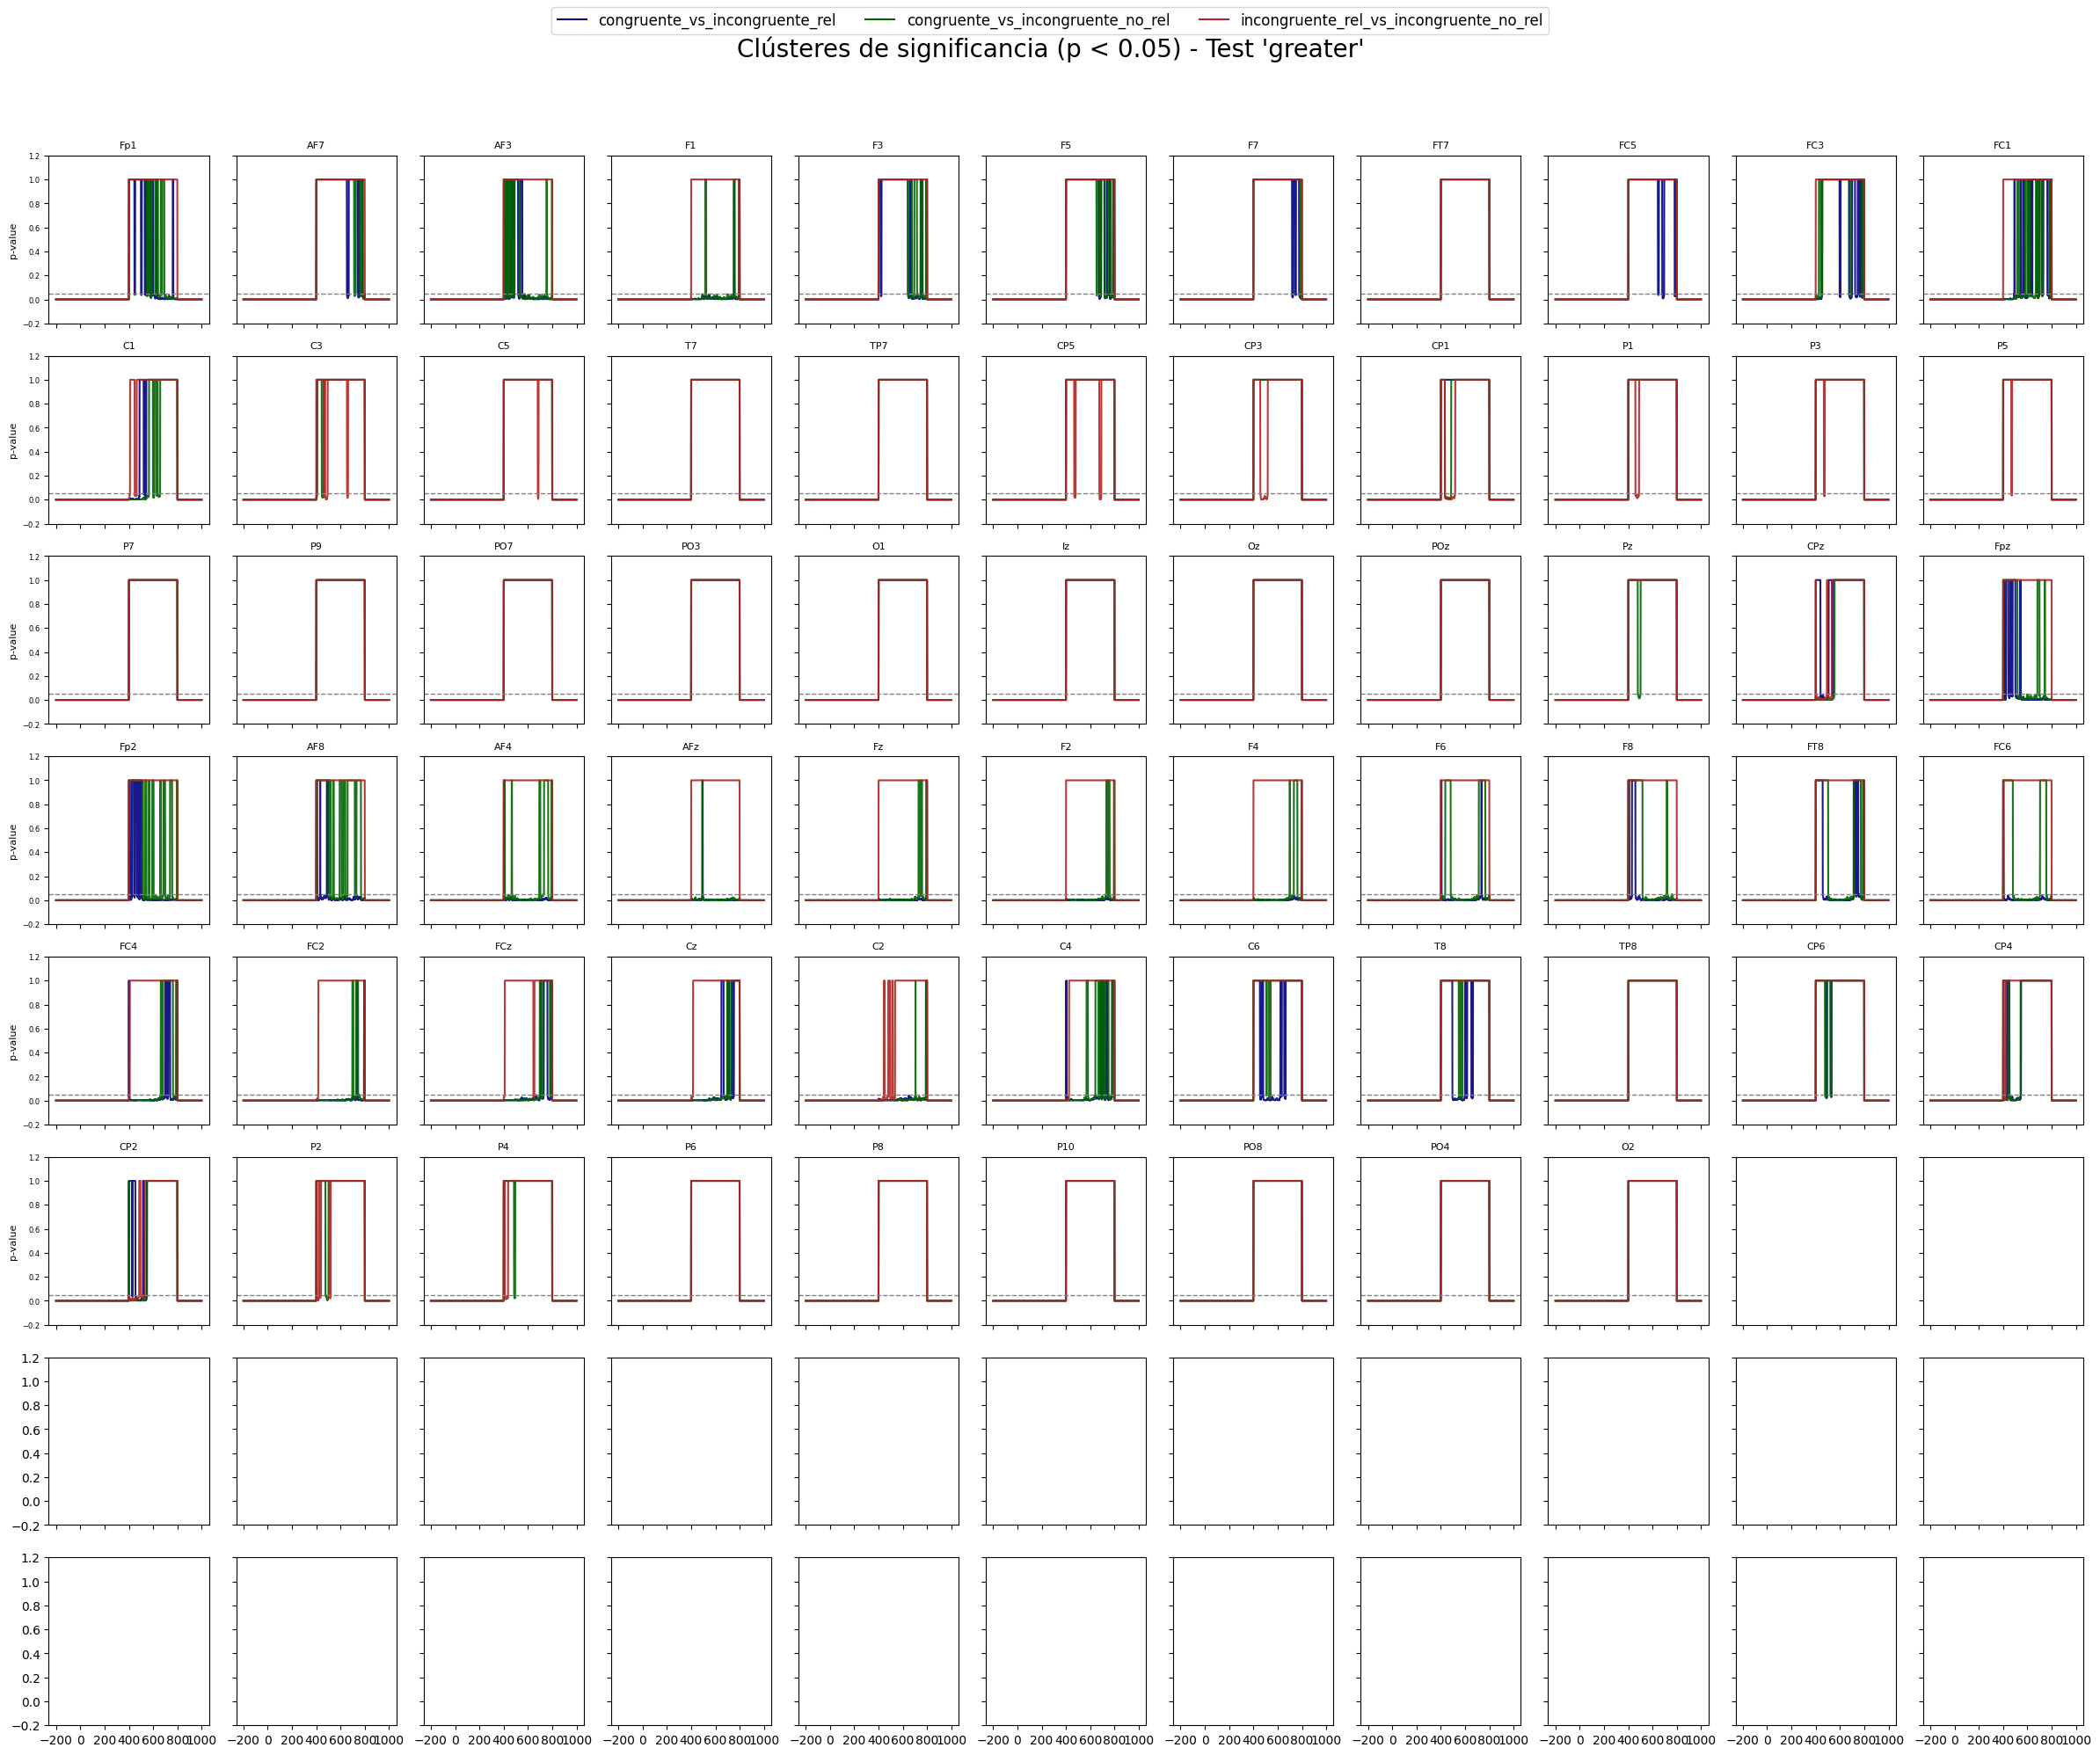

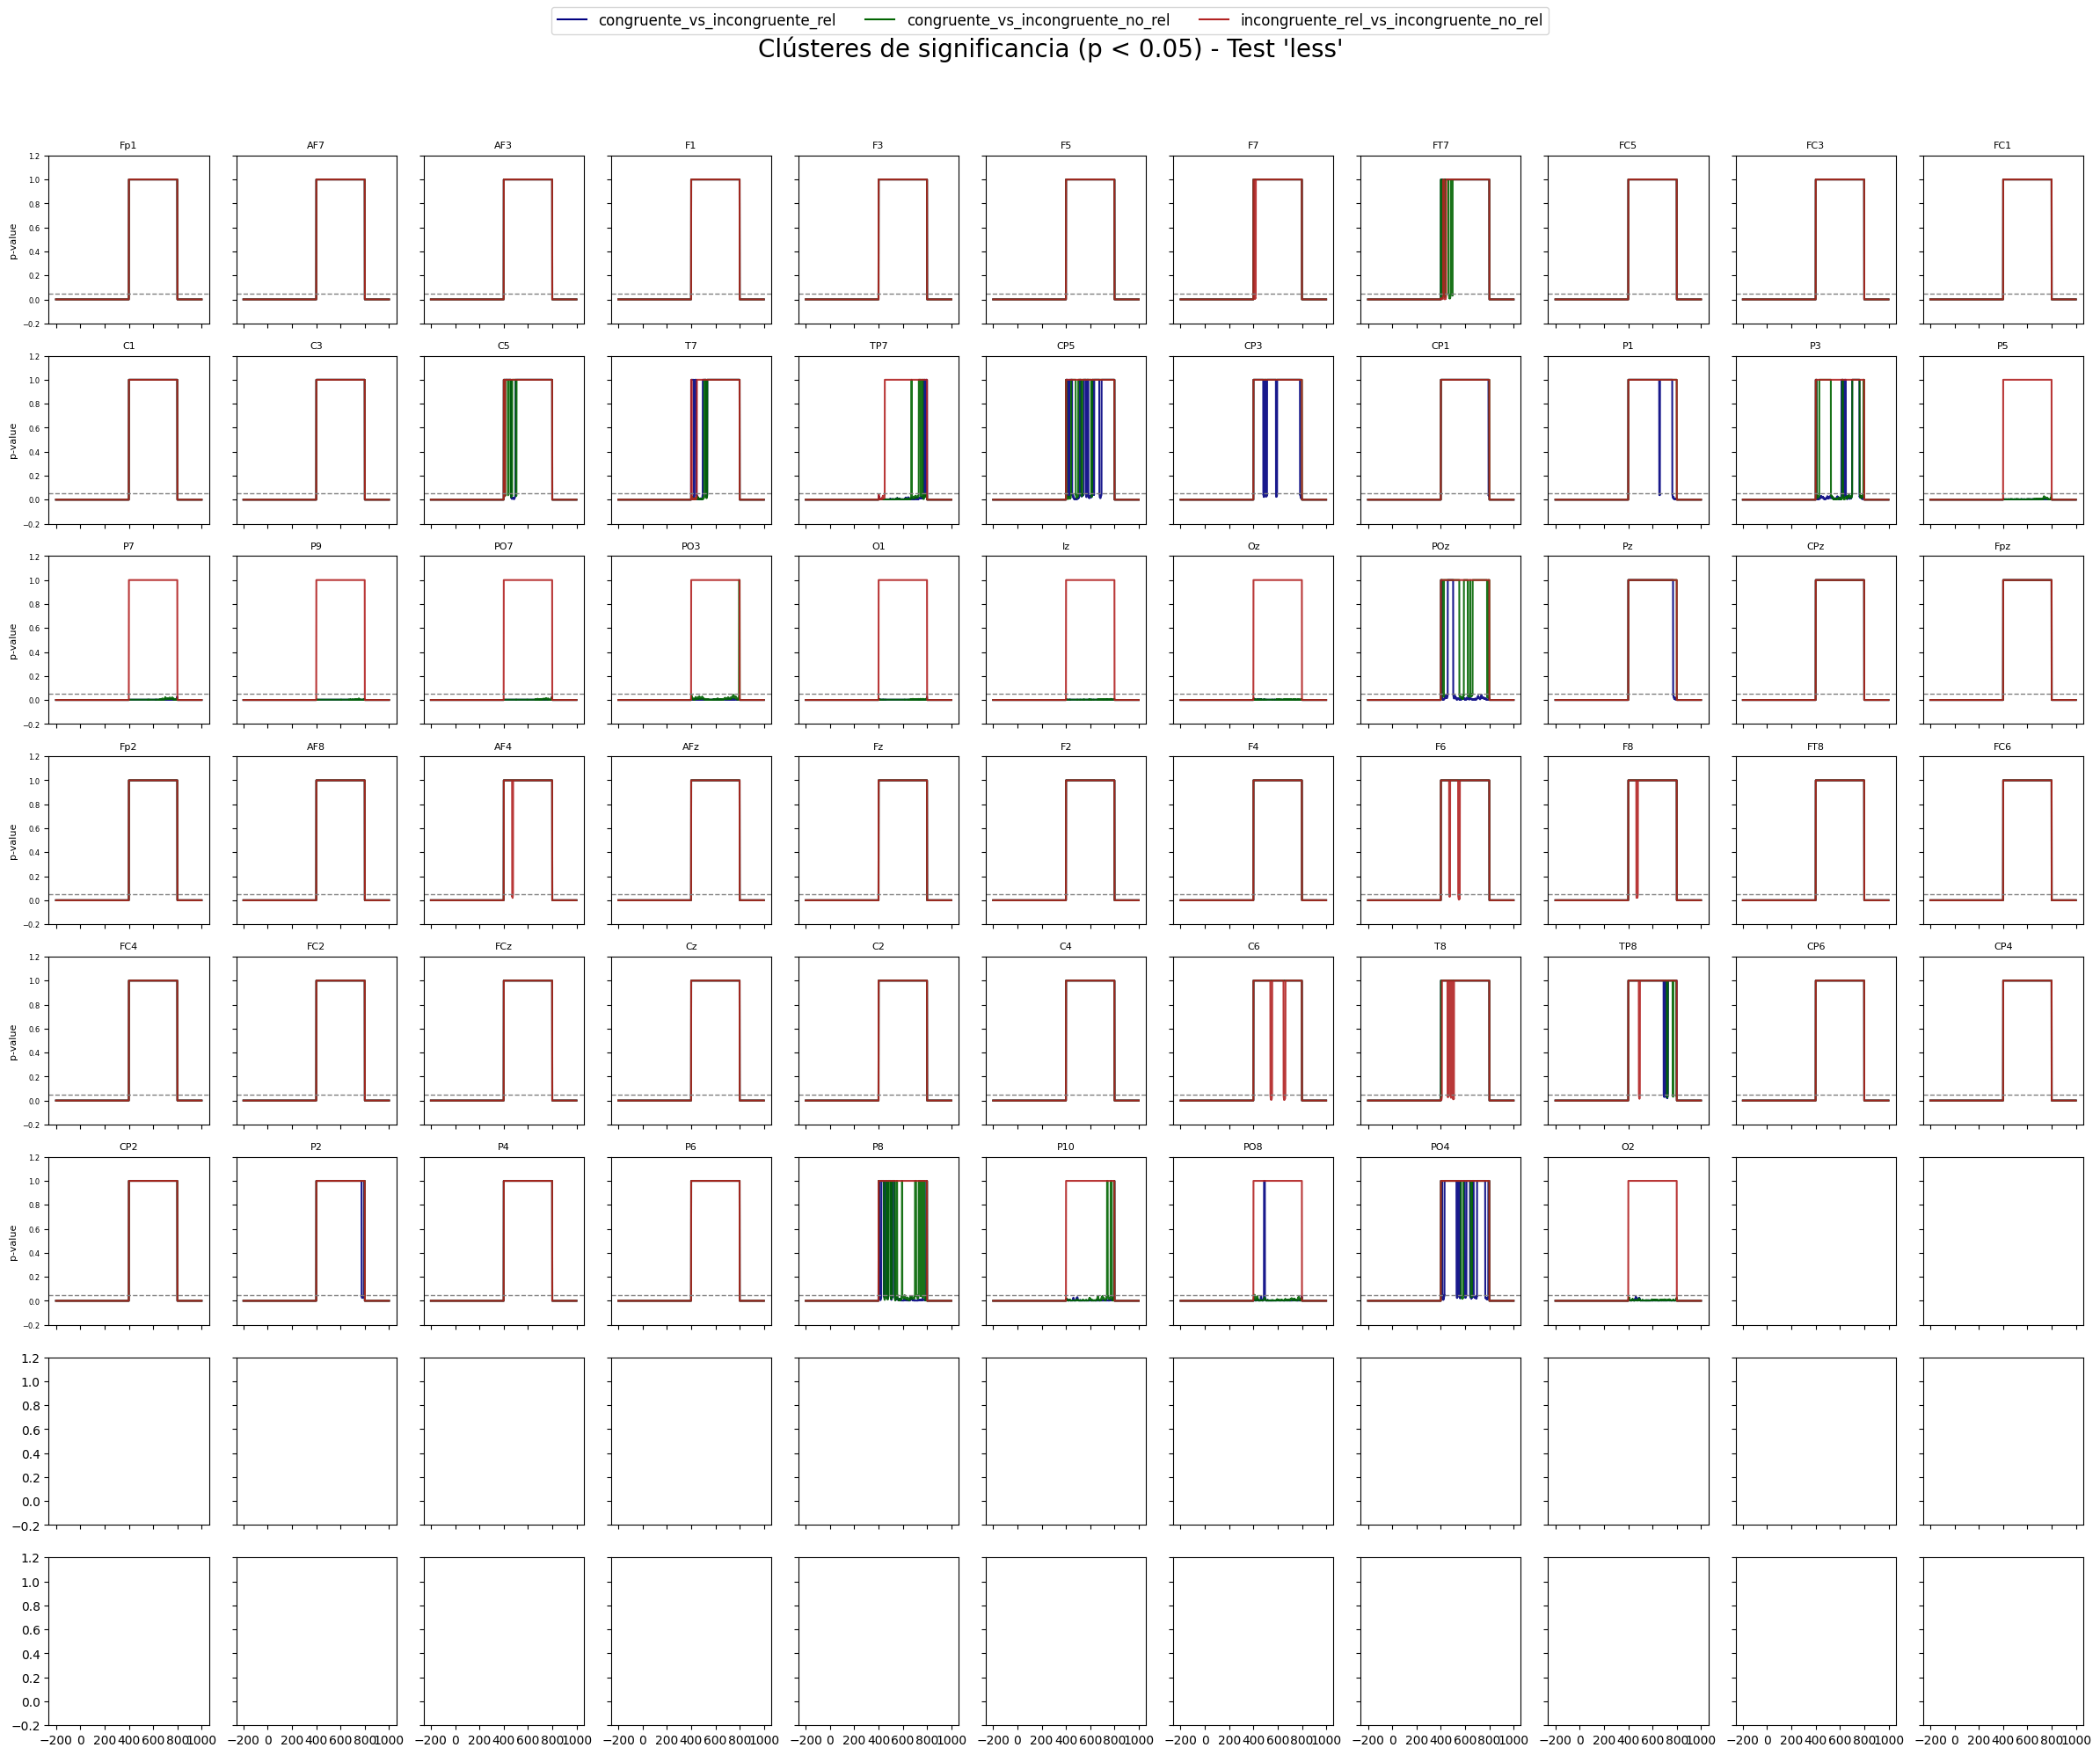

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Paleta de colores para comparaciones
comparisons_colors = {
    'congruente_vs_incongruente_rel': 'navy',
    'congruente_vs_incongruente_no_rel': 'darkgreen',
    'incongruente_rel_vs_incongruente_no_rel': 'firebrick'
}

# Frecuencia de muestreo y eje temporal
fs = 1024  # Hz
pre_stim_ms = -200
n_muestras = len(next(iter(greater_clusters.values()))['congruente_vs_incongruente_rel'])
tiempos_ms = np.arange(n_muestras) * (1000 / fs) + pre_stim_ms

# Layout 8x8 para 64 electrodos
rows, cols = 8, 11

# Crear carpeta para figuras si no existe
os.makedirs("figuras", exist_ok=True)

# Función general para graficar
def plot_clusters(p_values_clusters, title, filename):
    fig, axes = plt.subplots(rows, cols, figsize=(24, 20), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=20)

    for idx, (electrode, comps) in enumerate(p_values_clusters.items()):
        row, col = divmod(idx, cols)
        ax = axes[row][col]

        for comparison, pvals in comps.items():
            color = comparisons_colors.get(comparison, 'black')
            ax.plot(tiempos_ms, pvals, label=comparison, color=color, alpha=0.9)

        ax.axhline(y=0.05, color='gray', linestyle='--', linewidth=1)
        ax.set_title(electrode, fontsize=8)
        ax.set_ylim(-0.2, 1.2)
        ax.tick_params(labelsize=6)

        if row == rows - 1:
            ax.set_xlabel("Tiempo (ms)", fontsize=8)
        if col == 0:
            ax.set_ylabel("p-value", fontsize=8)

    # Leyenda global
    handles = [plt.Line2D([0], [0], color=c, label=comp) for comp, c in comparisons_colors.items()]
    fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # fig.savefig(f"figuras/{filename}.pdf", format='pdf')
    # fig.savefig(f"figuras/{filename}.svg", format='svg')
    plt.show()

# Graficar clusters greater
plot_clusters(
    greater_clusters,
    title="Clústeres de significancia (p < 0.05) - Test 'greater'",
    filename="clusters_significativos_greater"
)

# Graficar clusters less
plot_clusters(
    less_clusters,
    title="Clústeres de significancia (p < 0.05) - Test 'less'",
    filename="clusters_significativos_less"
)


In [7]:
def binarizar_clusters(clusters_dict):
    resultado = {}
    for electrodo in clusters_dict:
        resultado[electrodo] = {}
        for comparacion in clusters_dict[electrodo]:
            valores = np.array(clusters_dict[electrodo][comparacion])
            binario = (valores != 1.0).astype(int)
            resultado[electrodo][comparacion] = binario.tolist()
    return resultado


In [8]:
clusters_binarios_less = binarizar_clusters(less_clusters)
clusters_binarios_greater = binarizar_clusters(greater_clusters)


In [9]:
ch_names = list (greater_clusters.keys() )

In [12]:
import mne

# Comparaciones que vamos a graficar
comparaciones = ['congruente_vs_incongruente_rel', 
                 'congruente_vs_incongruente_no_rel', 
                 'incongruente_rel_vs_incongruente_no_rel']




# Parámetros de las ventanas
inicio_total = 400      # en ms
fin_total = 800         # en ms
tamano_ventana = 25     # ms
solapamiento = 12.5     # ms
umbral_proporcion = 0.5 # al menos 50% de la ventana debe ser significativa

# Generar ventanas en milisegundos
inicios = np.arange(inicio_total, fin_total - tamano_ventana + solapamiento, solapamiento)
ventanas_ms = [(round(start, 1), round(start + tamano_ventana, 1)) for start in inicios]

# Convertir ventanas a muestras (asumiendo sfreq = 1024 Hz y desplazamiento de 205 muestras)
ventanas_samples = [(int(start / 1000 * 1024) + 205, int(end / 1000 * 1024) + 205) for start, end in ventanas_ms]

# Crear info de EEG
montage = mne.channels.make_standard_montage("biosemi64")
ch_names = montage.ch_names[:64]
info = mne.create_info(ch_names=ch_names, sfreq=1024, ch_types="eeg")
info.set_montage(montage)

# Inicializar diccionario para guardar las matrices de significancia
matrices_significancia = {comp: [] for comp in comparaciones}

In [15]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# Configuración global para la fuente Arial y tamaño 12
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12
})


# Títulos personalizados
titulos = {
    'congruente_vs_incongruente_rel': 'Congruent vs Related Incongruent',
    'congruente_vs_incongruente_no_rel': 'Congruent vs Unrelated Incongruent',
    'incongruente_rel_vs_incongruente_no_rel': 'Related Incongruent vs Unrelated Incongruent'
}

# Graficar topomaps por ventana y comparación
for comp in comparaciones:
    for ventana_idx, (start_sample, end_sample) in enumerate(ventanas_samples):
        eeg_data_binaria = np.zeros(64)

        # Revisar canales significativos en la ventana (con criterio del 50%)
        for i, electrodo in enumerate(ch_names):
            if electrodo in clusters_binarios_greater and comp in clusters_binarios_greater[electrodo]:
                ventana = clusters_binarios_greater[electrodo][comp][start_sample:end_sample]
                proporcion_significancia = np.mean(ventana)
                if proporcion_significancia >= umbral_proporcion:
                    eeg_data_binaria[i] = 1
        # Guardar fila binaria de esta ventana
        matrices_significancia[comp].append(eeg_data_binaria.copy())


        # Asegurar que haya algo para visualizar
        data_plot = eeg_data_binaria.copy()
        # if np.all(data_plot == 0):
        #     data_plot += 0.000  # mínimo valor para que se renderice sin errores

        evoked = mne.EvokedArray(data_plot[:, np.newaxis], info)

        # # Plot
        # fig, ax = plt.subplots(figsize=(5, 4))
        # im, _ = mne.viz.plot_topomap(
        #     evoked.data[:, 0],
        #     evoked.info,
        #     cmap="viridis",
        #     contours=0,
        #     show=False,
        #     axes=ax,
        #     names=ch_names
        # )

        # # Ajustar límites del color entre 0 y 1 manualmente
        # im.set_clim(0, 1)

        # # Barra de color personalizada
        # cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Values')
        # cbar.set_ticks([0, 1])

        # # Título
        # ventana_titulo = f"{titulos[comp]} ({ventanas_ms[ventana_idx][0]}-{ventanas_ms[ventana_idx][1]} ms)"
        # ax.set_title(ventana_titulo, fontsize=14)

        # plt.tight_layout()
        # plt.show()

        # Imprimir electrodos activos
        # electrodos_activos = [ch_names[i] for i, v in enumerate(eeg_data_binaria) if v == 1]
        # print(f"Electrodos activos para {titulos[comp]} {ventanas_ms[ventana_idx][0]}-{ventanas_ms[ventana_idx][1]} ms:")
        # print(electrodos_activos)
        # print("-" * 60)


In [16]:
import pandas as pd
# Convertir las matrices a dataframes
df_matrices = {}
for comp in comparaciones:
    matriz = np.array(matrices_significancia[comp])
    df = pd.DataFrame(matriz, columns=ch_names[:64])
    df.index.name = "ventana"
    df_matrices[comp] = df

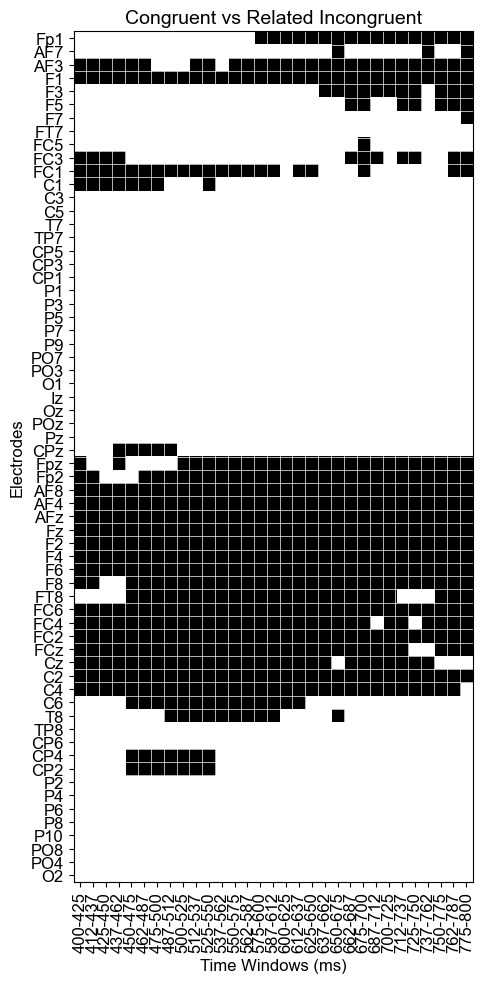

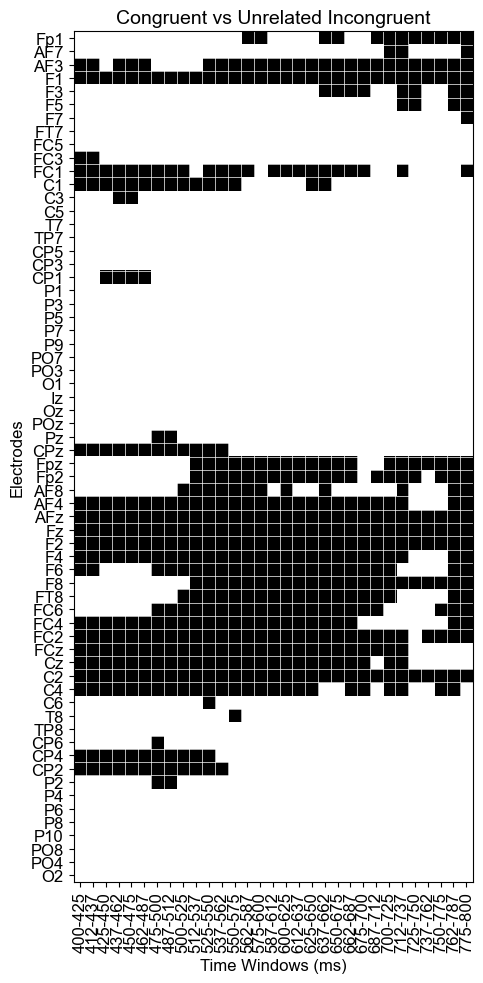

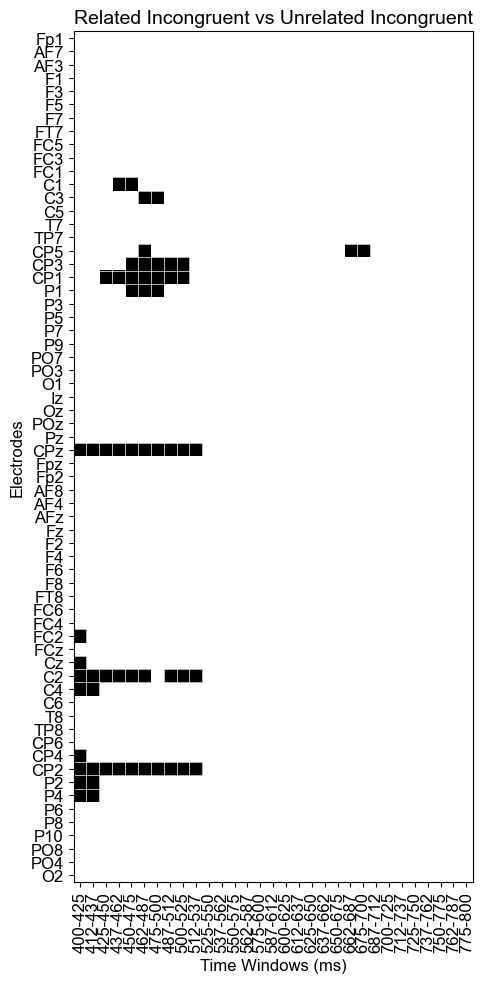

In [17]:
import matplotlib.pyplot as plt

for comp in comparaciones:
    df = df_matrices[comp].T  # Transponer: regiones en eje Y
    fig, ax = plt.subplots(figsize=(5, 10))

    # Mostrar matriz
    cax = ax.imshow(df.values, cmap='gray_r', aspect='auto', interpolation='none')

    # Agregar líneas blancas para bordes de celdas
    ax.set_xticks(np.arange(-0.5, len(df.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(df.index), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Etiquetas y formato
    ax.set_title(titulos[comp], fontsize=14)
    ax.set_ylabel("Electrodes", fontsize=12)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=12)

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels([f"{int(start)}-{int(end)}" for start, end in ventanas_ms],
                       rotation=90, fontsize=12)
    ax.set_xlabel("Time Windows (ms)", fontsize=12)

    

    plt.tight_layout()
    plt.show()


In [18]:
import pandas as pd
import numpy as np

def filtro_ventanas_consecutivas(df, min_consecutivas=4):
    df_filtrado = df.copy()

    for col in df.columns:
        arr = df[col].values
        # Detectar corridas consecutivas de 1
        max_run = 0
        current_run = 0
        run_indices = []

        # Guardar las posiciones de la corrida más larga (solo si es >= min_consecutivas)
        best_start = None
        best_end = None

        for i, val in enumerate(arr):
            if val == 1:
                current_run += 1
                if current_run >= min_consecutivas and (best_start is None or current_run > max_run):
                    max_run = current_run
                    best_end = i
                    best_start = i - current_run + 1
            else:
                current_run = 0

        # Si no hay corrida suficientemente larga, poner todo 0 en esa columna
        if max_run < min_consecutivas:
            df_filtrado[col] = 0
        else:
            # Poner a cero las ventanas que no formen parte de la corrida más larga válida
            new_col = np.zeros_like(arr)
            new_col[best_start:best_end + 1] = 1
            df_filtrado[col] = new_col

    return df_filtrado

# Aplicar a todos los DataFrames del diccionario
df_matrices_filtradas = {}
for comp, df in df_matrices.items():
    df_matrices_filtradas[comp] = filtro_ventanas_consecutivas(df, min_consecutivas=4)


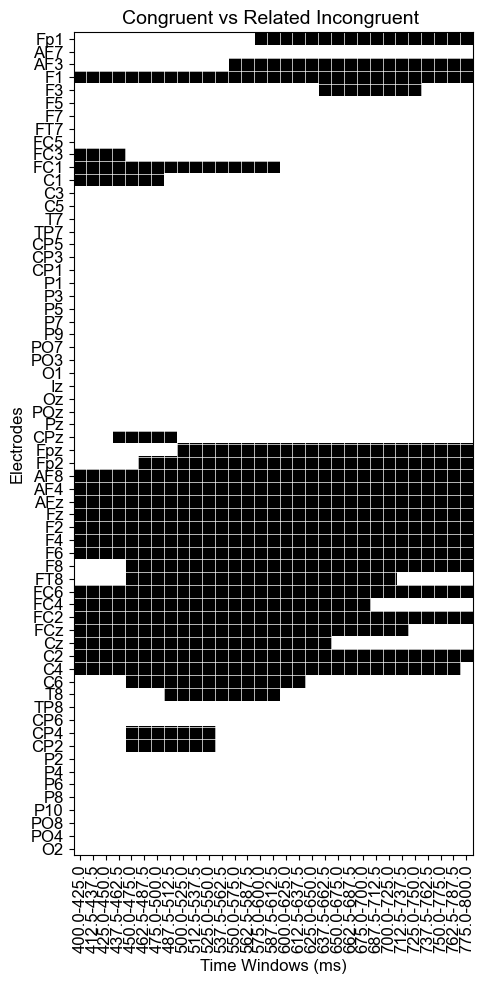

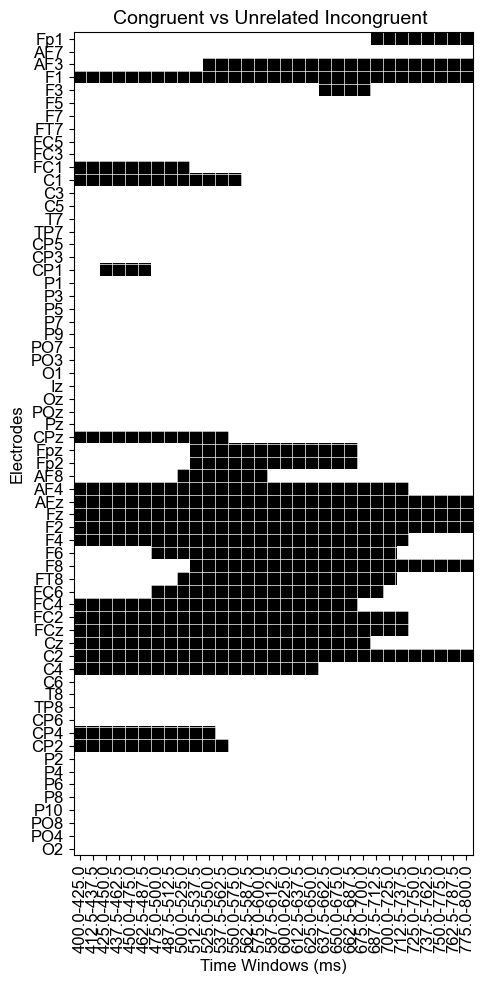

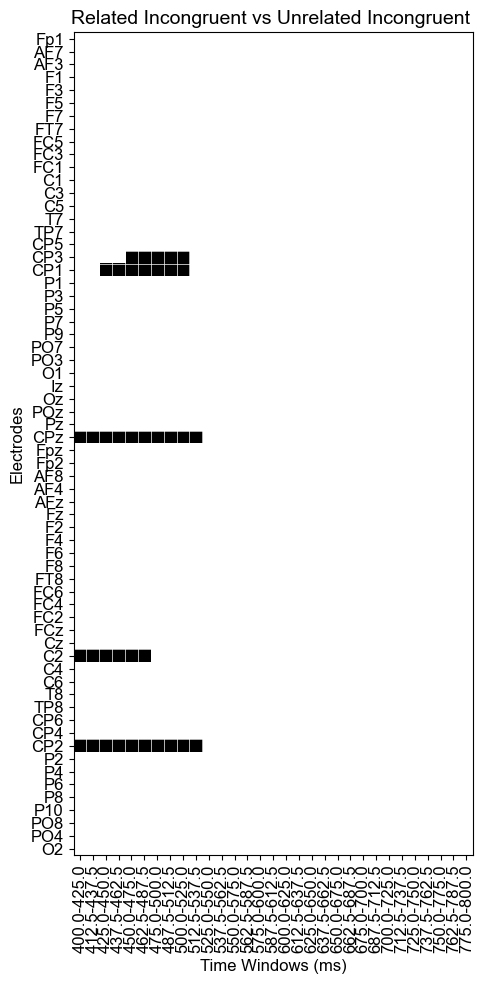

In [19]:
import matplotlib.pyplot as plt
import numpy as np

for comp in comparaciones:
    df = df_matrices_filtradas[comp].T  # Transponer para regiones en eje Y
    fig, ax = plt.subplots(figsize=(5, 10))

    # Mostrar matriz filtrada
    cax = ax.imshow(df.values, cmap='gray_r', aspect='auto', interpolation='none')

    # Líneas blancas para bordes de celdas
    ax.set_xticks(np.arange(-0.5, len(df.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(df.index), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Etiquetas y formato
    ax.set_title(titulos[comp] + " ", fontsize=14)
    ax.set_ylabel("Electrodes", fontsize=12)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, fontsize=12)

    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels([f"{start:.1f}-{end:.1f}" for start, end in ventanas_ms],
                   rotation=90, fontsize=12)
    ax.set_xlabel("Time Windows (ms)", fontsize=12)

    plt.tight_layout()
    plt.show()


In [20]:
import pandas as pd

# Diccionario para guardar los promedios por condición
promedios_por_condicion = {}

for condicion, df in df_matrices_filtradas.items():
    # Calcula la media por electrodo (columnas)
    promedio = df.mean(axis=0)
    promedios_por_condicion[condicion] = promedio

# Si quieres convertir a DataFrame final: filas = condiciones, columnas = electrodos
df_promedios = pd.DataFrame(promedios_por_condicion).T


In [24]:
data_plot = registros_eeg['congruente']['Sujeto_1']


In [27]:
info = data_plot.info  # Información de los datos EEG


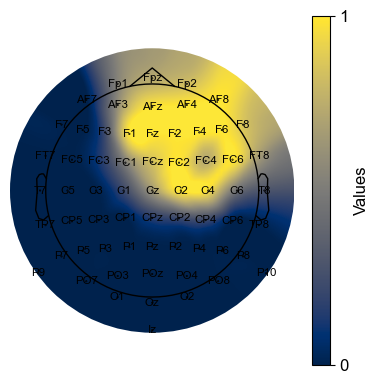

In [28]:
evoked = mne.EvokedArray(promedios_por_condicion['congruente_vs_incongruente_rel'].values[:, np.newaxis], info)

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
im, _ = mne.viz.plot_topomap(
    evoked.data[:, 0],
    evoked.info,
    cmap="cividis",
    contours=0,
    show=False,
    axes=ax,
    names=ch_names
)

# Ajustar límites del color entre 0 y 1 manualmente
im.set_clim(0, 1)

# Barra de color personalizada
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Values')
cbar.set_ticks([0, 1])

# Título
ventana_titulo = ""
ax.set_title(ventana_titulo, fontsize=14)

fig.savefig(f"figuras/topoplot_congruente_vs_incongruente_rel.pdf", format='pdf')
fig.savefig(f"figuras/topoplot_congruente_vs_incongruente_rel.svg", format='svg')

plt.tight_layout()
plt.show()

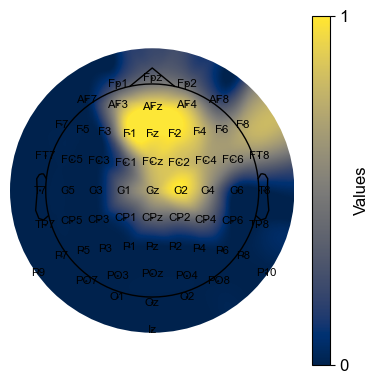

In [29]:
evoked = mne.EvokedArray(promedios_por_condicion['congruente_vs_incongruente_no_rel'].values[:, np.newaxis], info)

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
im, _ = mne.viz.plot_topomap(
    evoked.data[:, 0],
    evoked.info,
    cmap="cividis",
    contours=0,
    show=False,
    axes=ax,
    names=ch_names
)

# Ajustar límites del color entre 0 y 1 manualmente
im.set_clim(0, 1)

# Barra de color personalizada
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Values')
cbar.set_ticks([0, 1])

# Título
ventana_titulo = ""
ax.set_title(ventana_titulo, fontsize=14)

fig.savefig(f"figuras/topoplot_congruente_vs_incongruente_no_rel.pdf", format='pdf')
fig.savefig(f"figuras/topoplot_congruente_vs_incongruente_no_rel.svg", format='svg')


plt.tight_layout()
plt.show()

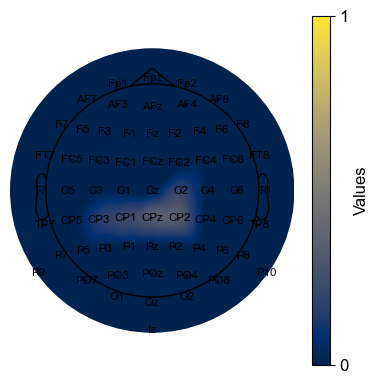

In [30]:
evoked = mne.EvokedArray(promedios_por_condicion['incongruente_rel_vs_incongruente_no_rel'].values[:, np.newaxis], info)

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
im, _ = mne.viz.plot_topomap(
    evoked.data[:, 0],
    evoked.info,
    cmap="cividis",
    contours=0,
    show=False,
    axes=ax,
    names=ch_names
)

# Ajustar límites del color entre 0 y 1 manualmente
im.set_clim(0, 1)

# Barra de color personalizada
cbar = fig.colorbar(im, ax=ax, orientation='vertical', label='Values')
cbar.set_ticks([0, 1])

# Título
ventana_titulo = ""
ax.set_title(ventana_titulo, fontsize=14)
fig.savefig(f"figuras/topoplot_incongruente_rel_vs_incongruente_no_rel.pdf", format='pdf')
fig.savefig(f"figuras/topoplot_incongruente_rel_vs_incongruente_no_rel.svg", format='svg')

plt.tight_layout()
plt.show()